In [1]:
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import zipfile
import io
import matplotlib.pyplot as plt
import imageio
import pandas as pd
import os
import time
from datetime import datetime

# see the lab documentation for details of the unet models
from common_blocks import down_block, up_block

%matplotlib inline


## Models

In [2]:
# RCNN convnet1 
class convnet1(nn.Module):
    def __init__(self, in_ch=3, n_channels=8):
        super(convnet1, self).__init__()
        self.activation = F.relu
        
        self.conv1 = nn.Conv2d(in_ch, n_channels, kernel_size= 1, padding=0)
        self.conv2 = nn.Conv2d(n_channels, 1, kernel_size= 1, padding=0)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.activation(out)
        out = self.conv2(out)
        
        return out
    
## Unet1
class unet1(nn.Module):
    def __init__(self, in_ch=3, n_channels=8):
        super(unet1, self).__init__()
        self.activation = F.relu
        
        self.down1 = down_block(in_ch, n_channels)

        self.bridge = down_block(in_ch=n_channels, out_ch=n_channels*2, max_pooling=False)

        self.up1 = up_block(in_ch=n_channels*2, out_ch=n_channels)
        self.final_conv = nn.Conv2d(n_channels, 1, kernel_size= 1, padding=0)
    
    def forward(self, x):
        out, skip1 = self.down1(x)
        out, _ = self.bridge(out)
        
        out = self.up1(out, skip1)
        out = self.final_conv(out)
        
        return out

## Unet2
class unet2(nn.Module):
    def __init__(self, in_ch=3, n_channels=8):
        super(unet2, self).__init__()
        
        self.down1 = down_block(in_ch, n_channels)
        self.down2 = down_block(in_ch=n_channels, out_ch=n_channels*2)

        self.bridge= down_block(in_ch=n_channels*2, out_ch=n_channels*4, max_pooling=False)

        self.up1 = up_block(in_ch=n_channels*4, out_ch=n_channels*2)
        self.up2 = up_block(in_ch=n_channels*2, out_ch=n_channels)
        self.final_conv = nn.Conv2d(n_channels, 1, kernel_size= 1, padding=0)
    
    def forward(self, x):
        out, skip1 = self.down1(x)
        out, skip2 = self.down2(out)

        out, _ = self.bridge(out)

        out = self.up1(out, skip2)
        out = self.up2(out, skip1)
        out = self.final_conv(out)
        
        return out

## Custom Dataset

In [3]:
# utility function to display input image and its segmentation side by side
def display_images(label, input_img, seg_img, pred_img=None):
    # input_img = channels x width x height array
    # seg_img = 1 x width x height array
    # pred_img = 1 x width x height array (optional)
    
    input_img = np.moveaxis(input_img, 0, -1)
    seg_img = np.squeeze(seg_img)
    
    if pred_img is None:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    else:
        fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    axes[0].imshow(input_img)
    axes[0].set_title('Input')
    axes[1].imshow(seg_img, cmap='gray')
    axes[1].set_title('Target')
    
    if pred_img is not None:
        pred_img = np.squeeze(pred_img)
        axes[2].imshow(pred_img, cmap='gray')
        axes[2].set_title('Prediction')
    fig.suptitle(label)

    
class SegmentationDataset():
    """
    img_dir = directory containing images
    labels = list of image labels
    """
    def __init__(self, img_dir, labels):
        self.img_dir = img_dir
        self.labels  = labels
        
    def __getitem__(self, index):
        label = self.labels[index]
        img_id = label.split(".")[0][2:]
        input_img_label = "im%s.png" % img_id
        seg_img_label = "imseg%s.png" % img_id
        input_img_path = os.path.join(self.img_dir, input_img_label)
        seg_img_path = os.path.join(self.img_dir, seg_img_label)
        
        input_img = np.asarray(imageio.imread(input_img_path))
        seg_img = np.asarray(imageio.imread(seg_img_path))

        input_img = input_img / 255.0
        input_img = np.moveaxis(input_img, -1, 0)
        seg_img = seg_img / 255
        seg_img = np.expand_dims(seg_img, axis=0)

        return label, input_img, seg_img
    
    def __len__(self):
        return len(self.labels)


## Download and Initialize the custom datasets

In [4]:
# If on JHUB use local dataset else download
JHUB = 1

#select the dataset
#
# 16 x 16 color digits
#dsetn = "lab9data1"
# 16 x 16 red digits
#dsetn = "lab9data1r"
# 16 x 16 red digits
#dsetn = "lab9data2"
# 16 x 16 red digits
#dsetn = "lab9data2r"
# 64 x 64 images with color digits
dsetn = "lab9data3"
# 64 x 64 images with red digits
#dsetn = "lab9data3r"

## On JHUB use downloaded dataet
if  JHUB:
   dset = "/classes/ece5470/lab/lab9/" + dsetn
else:
    dset = dsetn
    url = 'https://www.via.cornell.edu/ece5470/' + dsetn + '.zip'
    r = requests.get(url).content
    z = zipfile.ZipFile(io.BytesIO(r))
    z.extractall('./' + dset)

labels_df = pd.read_csv(os.path.join(dset, "labels.csv"))
labels = labels_df.iloc[:, 0].values

print("Total number of images:", len(labels))

test_labels = labels[:100]
val_labels = labels[100:200]
#train_labels = labels[200:]
train_labels = labels[200:700]


Total number of images: 1000


In [5]:
# Load Images
train_dataset = SegmentationDataset(dset, train_labels)
val_dataset   = SegmentationDataset(dset, val_labels)
test_dataset  = SegmentationDataset(dset, test_labels)


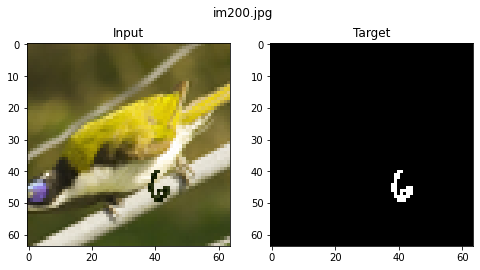

In [6]:
# show example input image/segmentation pairs
elist = iter(train_dataset)
for idx in range(1):
    label, input_img, target = next(elist)   
    display_images(label, input_img, target)


# Training and Evaluation functions

In [7]:
def train(model, train_loader, optimizer, loss_fn):
    model.train()
    avg_loss = 0

    for batch_idx, (label, data, target) in enumerate(train_loader):
        data = data.float()
        target = target.float()
        
        optimizer.zero_grad()
        output = model(data)

        loss = loss_fn(output, target)

        loss.backward()
        optimizer.step()
        avg_loss += (loss.item() * data.size(0) / len(train_loader.sampler))

        if batch_idx % 10 == 0 and batch_idx > 0:
            print('  [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return avg_loss

def eval(model, val_loader, loss_fn):
    model.eval()
    avg_loss = 0

    with torch.no_grad():
        for batch_idx, (label, data, target) in enumerate(val_loader):
            data = data.float()
            target = target.float()

            output = model(data)

            loss = loss_fn(output, target)

            avg_loss += (loss.item() * data.size(0) / len(val_loader.sampler))

    return avg_loss

## Main


In [8]:
BATCH_SIZE = 16
NUM_EPOCHS = 15
LEARNING_RATE = 1e-2

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

""" initialization """
model = convnet1()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_fn = nn.BCEWithLogitsLoss()

""" cooking """
train_losses = []
val_losses = []
best_val_loss = np.inf

start_time = datetime.now()
for epoch in range(NUM_EPOCHS):
    print("------- Epoch", epoch+1, "-------")
    print("  Training")
    train_loss = train(model, train_loader, optimizer, loss_fn)
    print("     Loss =", train_loss)
    print("  Validation")
    val_loss   = eval(model, val_loader, loss_fn)
    print("     Loss =", val_loss)

    val_losses.append(val_loss)
    train_losses.append(train_loss)
    
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), "best_model.pth") # remember to change the filename if you don't want to overwrite the saved checkpoint
        best_val_loss = val_loss
print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

------- Epoch 1 -------
  Training
  [160/500 (31%)] Loss: 0.572940
  [320/500 (62%)] Loss: 0.399710
  [480/500 (94%)] Loss: 0.228455
     Loss = 0.4883456419706344
  Validation
     Loss = 0.20488970160484313
------- Epoch 2 -------
  Training
  [160/500 (31%)] Loss: 0.100182
  [320/500 (62%)] Loss: 0.077158
  [480/500 (94%)] Loss: 0.067494
     Loss = 0.10570927554368974
  Validation
     Loss = 0.0703239843249321
------- Epoch 3 -------
  Training
  [160/500 (31%)] Loss: 0.076611
  [320/500 (62%)] Loss: 0.063645
  [480/500 (94%)] Loss: 0.056242
     Loss = 0.06531977587938306
  Validation
     Loss = 0.06720597684383392
------- Epoch 4 -------
  Training
  [160/500 (31%)] Loss: 0.072536
  [320/500 (62%)] Loss: 0.063765
  [480/500 (94%)] Loss: 0.066934
     Loss = 0.06352269983291625
  Validation
     Loss = 0.06574649631977081
------- Epoch 5 -------
  Training
  [160/500 (31%)] Loss: 0.058665
  [320/500 (62%)] Loss: 0.059418
  [480/500 (94%)] Loss: 0.055909
     Loss = 0.0621343414

# Evaluation

In [9]:
def plot_loss_curves(train_losses, val_losses):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    ax.plot(train_losses)
    ax.plot(val_losses)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'])

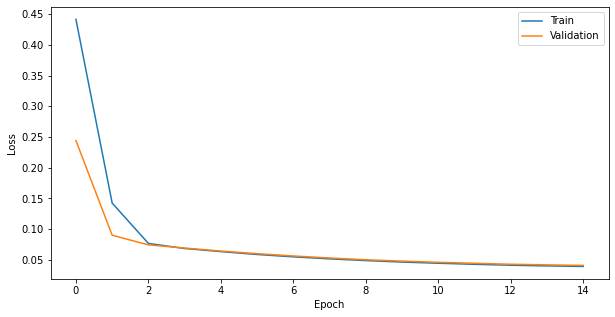

In [10]:
plot_loss_curves(train_losses, val_losses)

In [11]:
def compute_dice_score(im1, im2):
    # compute Dice score between 2 binary images im1 and im2
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape")

    denom = im1.sum() + im2.sum()
    if denom == 0:
        return None

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / denom


In [12]:
def predict(model, test_loader, threshold=0.5):
    model.eval()

    pred = []
    with torch.no_grad():
        for batch_idx, (label, data, target) in enumerate(test_loader):
            data = data.float()
            target = target.float()

            output = torch.sigmoid(model(data))
            output[output >= threshold] = 1 # binarize the prediction at threshold
            output[output < threshold] = 0
            
            for i in range(target.shape[0]):
                sample_label = label[i]
                sample_data = data[i, :, :, :]
                sample_target = target[i, :, :, :]
                sample_pred = output[i, :, : , :]
                
                dice = compute_dice_score(sample_target, sample_pred)
            
                pred.append({
                    "label": sample_label,
                    "input": sample_data.numpy(),
                    "target": sample_target.numpy(),
                    "pred": sample_pred.numpy(),
                    "dice": dice
                })
    return pred


In [20]:
test_loader   = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

start_time = datetime.now()
pred = predict(model, test_loader, threshold=0.05)
print("Average Dice score =", np.mean([sample["dice"] for sample in pred]))
print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))

Average Dice score = 0.1938452413288475
Time Elapsed: 0.26338 seconds


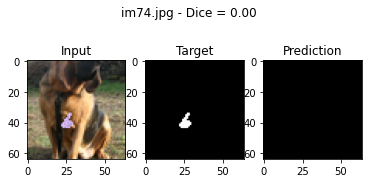

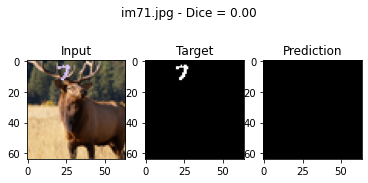

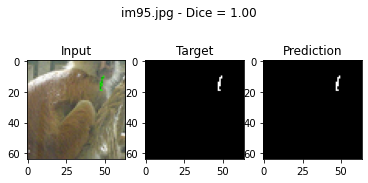

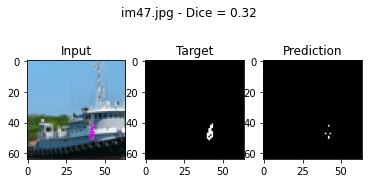

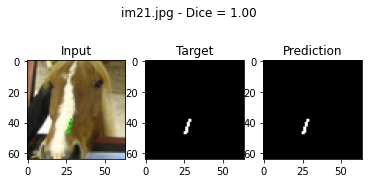

In [21]:
# show example results

for idx in range(5):
    random_sample = np.random.choice(pred)
    display_images("%s - Dice = %.2f" % (random_sample["label"], random_sample["dice"]), random_sample["input"], random_sample["target"], random_sample["pred"])


Average Dice score for threshold 0.05 = 0.1938452413288475
Time Elapsed: 0.583543 seconds
Average Dice score for threshold 0.025 = 0.5510887611054143
Time Elapsed: 0.905916 seconds
Average Dice score for threshold 0.05 = 0.1938452413288475
Time Elapsed: 1.169257 seconds
Average Dice score for threshold 0.1 = 0.15268259738489134
Time Elapsed: 1.446234 seconds
Average Dice score for threshold 0.12 = 0.14551983039071284
Time Elapsed: 1.752192 seconds
Average Dice score for threshold 0.3 = 0.12
Time Elapsed: 2.005387 seconds
Average Dice score for threshold 0.5 = 0.11728684021972775
Time Elapsed: 2.306612 seconds


Text(0.5, 0, 'Threshold')

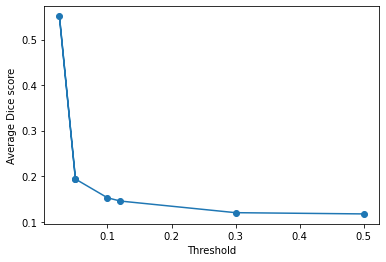

In [19]:
test_loader   = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

x=[0.05, 0.025, 0.05, 0.1, 0.12, 0.3, 0.5]     #x is the set of threshold values. You can modify it.
y=[]
start_time = datetime.now()
for i in x:
    pred = predict(model, test_loader, threshold=i)
    mp=np.mean([sample["dice"] for sample in pred])
    print("Average Dice score for threshold",i, "=",mp)
    print("Time Elapsed: {} seconds".format((datetime.now() - start_time).total_seconds()))
    y.append(mp)

#plotting Average Dice score based on given thrshold values
fig, ax = plt.subplots()
ax.plot(x,y,'-o')
ax.set_ylabel('Average Dice score')
ax.set_xlabel('Threshold')